# Introduction

The multi-objective problem arises frequently in experimental campaigns.
Consider the following example. Suppose you are synthesizing nanoparticles (NP)
in solution with respect to two experimental parameters: synthesis temperature
$T$ and some precursor concentration $c$. The result is a population of NPs of
various sizes (as measured by NP radius). This population results in an average
radius $r$ and a polydispersity $\sigma$ given by the standard deviation of the
NP radius distribution.

Your objective is to identify the optimal synthesis parameters $x = (T, c)$ that
result in NPs with 1) a specific average radius target $r^\star$ and 2) minimal
NP size polydispersity. This is an example of a multi objective problem, namely
two objectives: targeting of $r$, and minimization of $\sigma$.

We can treat the observed NP average radius and polydispersity as functions of
synthesis conditions $x$, writing $r(x)$ and $\sigma(x)$. For any given $x$, we
assume that we can make *noisy observations*:

\begin{align}
\hat r(x) &= r(x) + W_r, \\
\hat \sigma(x) &= \sigma(x) + W_\sigma,
\end{align}

where $W_r$ and $W_\sigma$ are additive Gaussian noise with known variance (we
know the size of the noise in our observations). We also assume a correlation
between $r$ and $\sigma$: populations with small and large average radii have
small polydispersity, whereas populations with medium average radii have large
polydispersity.

Below, we make a few attempts at modeling this situation and solving the
multi-objective problem, and then compare the various attempts with respect
to some performance metrics.

## Data generation
First, we'll define the ground truth *in silico* in lieu of actually running
experiments, then use the ground truth to generate some data. Below we define
this ground truth, and sample parameters for this ground truth.

In [63]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import itertools

SEED = 123456
RNG = np.random.default_rng(seed=SEED)
FEATURIZER = PolynomialFeatures(degree=2)

def f_truth(x, params):
    X = FEATURIZER.fit_transform(x)
    r = X @ params['theta'] # radius
    p = (r - params['r_min'])/(params['r_max'] - params['r_min'])
    sigma = -1.0*params['sigma_0'] * p * np.log(p+1e-6) # polydispersity
    return r, sigma

def sample_parameters(x):
    X = FEATURIZER.fit_transform(x)
    X_med = np.mean(X, axis = 0)
    theta = RNG.uniform(low=0, high=1/X_med) # sample coefficients
    r = X @ theta # model predictions of radius, use to define reset of params
    r_min = np.min(r)
    r_max = np.max(r)
    sigma_0 = 2*np.std(r)
    return {'theta': theta, 'r_min': r_min, 'r_max': r_max, 'sigma_0': sigma_0}

# The query set of experimental inputs
D = 50
temp_query, conc_query = np.linspace(0, 1, num=D), np.linspace(0, 1, num=D)
x_query = np.array(list(itertools.product(temp_query, conc_query))) # all combos

# Sample the parameters for ground truth
true_params = sample_parameters(x_query)

Now we can evaluate the ground truth at various synthesis conditions and plot
the output variables. We can also form experimentally observed data set by
adding noise to these evaluations of the ground truth.

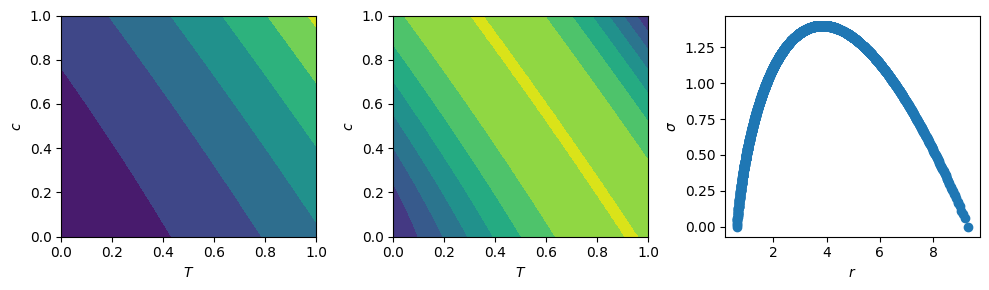

In [66]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100

# Evaluate the ground truth at each of the query points
r_query, sigma_query = f_truth(x_query, true_params)

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.contourf(x_query[:,0].reshape(D, D), x_query[:,1].reshape(D, D),
             r_query.reshape(D, D))
plt.xlabel(r'$T$')
plt.ylabel(r'$c$')

plt.subplot(1,3,2)
plt.contourf(x_query[:,0].reshape(D, D), x_query[:,1].reshape(D, D),
             sigma_query.reshape(D, D))
plt.xlabel(r'$T$')
plt.ylabel(r'$c$')

plt.subplot(1,3,3)
plt.scatter(r_query, sigma_query)
plt.xlabel(r'$r$')
plt.ylabel(r'$\sigma$')
plt.tight_layout()